# UFC 경기 승패 예측 프로젝트 (PCA 제거 최종본)

## 1. 프로젝트 개요
**주제**: UFC 파이터들의 과거 데이터와 경기 기록을 기반으로 경기 승패를 예측하는 머신러닝 모델 개발
**목표**: 다양한 모델을 비교하고, 최종적으로 스태킹(Stacking) 앙상블 기법을 적용하여 최적의 예측 모델을 구축하는 것을 목표로 합니다.

## 2. 라이브러리 임포트 및 데이터 로드

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [41]:
# 한글 폰트 사용을 위한 설정
import matplotlib.font_manager as fm 
import matplotlib 

font_path = 'C:/Windows/Fonts/gulim.ttc'
font = fm.FontProperties(fname=font_path).get_name()
matplotlib.rc('font', family=font)

In [42]:
df = pd.read_csv('UFC.csv')

## 3. 데이터 전처리 및 EDA

In [43]:
# Unnamed 컬럼 제거
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
# 무승부 경기 제거
df.dropna(subset=['winner'], inplace=True)
# 필수 정보(DOB) 누락 행 제거
df.dropna(subset=['r_dob', 'b_dob'], inplace=True)
# Stance 결측치 처리
df['r_stance'].fillna('Orthodox', inplace=True)
df['b_stance'].fillna('Orthodox', inplace=True)
# Reach 결측치 처리
df['r_reach'].fillna(df['r_height'], inplace=True)
df['b_reach'].fillna(df['b_height'], inplace=True)
# 나머지 숫자형 결측치 0으로 채우기
num_cols = df.select_dtypes(include=np.number).columns
df[num_cols] = df[num_cols].fillna(0)

print(f'최종 결측치 개수: {df.isnull().sum().sum()}')

최종 결측치 개수: 25


### 3.1. 타겟 변수 및 특성 공학

In [44]:
# 타겟 변수 생성
df['winner_is_red'] = (df['winner'] == df['r_name']).astype(int)

# 나이 계산
df['r_dob'] = pd.to_datetime(df['r_dob'])
df['b_dob'] = pd.to_datetime(df['b_dob'])
df['r_age'] = (pd.to_datetime('today') - df['r_dob']).dt.days / 365.25
df['b_age'] = (pd.to_datetime('today') - df['b_dob']).dt.days / 365.25

# 이긴 선수 특성 정보
cols = ['name', 'wins', 'losses', 'draws', 'height', 'weight', 'reach', 'stance', 'age', 'splm', 'str_acc', 'sapm', 'str_def', 'td_avg', 'td_acc', 'td_def', 'sub_avg', 'total_games']
df['r_total_games'] = df['r_wins'] + df['r_losses']
df['b_total_games'] = df['b_wins'] + df['b_losses']

# 결합
for col in cols:
    r_col = f"r_{col}"
    b_col = f"b_{col}"
    winner_col = f"w_{col}"
    
    df[winner_col] = np.where(df['winner_is_red'] == 1, df[r_col], df[b_col])

# 차이 특성 생성
df['age_diff'] = df['r_age'] - df['b_age']
df['height_diff'] = df['r_height'] - df['b_height']
df['weight_diff'] = df['r_weight'] - df['b_weight']
df['reach_diff'] = df['r_reach'] - df['b_reach']
df['wins_diff'] = df['r_wins'] - df['b_wins']
df['losses_diff'] = df['r_losses'] - df['b_losses']
df['splm_diff'] = df['r_splm'] - df['b_splm']
df['str_acc_diff'] = df['r_str_acc'] - df['b_str_acc']
df['sapm_diff'] = df['r_sapm'] - df['b_sapm']
df['str_def_diff'] = df['r_str_def'] - df['b_str_def']
df['td_avg_diff'] = df['r_td_avg'] - df['b_td_avg']
df['td_acc_diff'] = df['r_td_avg_acc'] - df['b_td_avg_acc']
df['td_def_diff'] = df['r_td_def'] - df['b_td_def']
df['sub_avg_diff'] = df['r_sub_avg'] - df['b_sub_avg']
df['total_games_diff'] = df['r_total_games'] - df['b_total_games']

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7904 entries, 0 to 8237
Columns: 156 entries, fight_id to total_games_diff
dtypes: datetime64[ns](2), float64(106), int64(34), object(14)
memory usage: 9.5+ MB


In [46]:
print(list(df.columns))

['fight_id', 'division', 'title_fight', 'method', 'finish_round', 'match_time_sec', 'total_rounds', 'referee', 'r_name', 'r_id', 'r_kd', 'r_sig_str_landed', 'r_sig_str_atmpted', 'r_sig_str_acc', 'r_total_str_landed', 'r_total_str_atmpted', 'r_total_str_acc', 'r_td_landed', 'r_td_atmpted', 'r_td_acc', 'r_sub_att', 'r_ctrl', 'r_head_landed', 'r_head_atmpted', 'r_head_acc', 'r_body_landed', 'r_body_atmpted', 'r_body_acc', 'r_leg_landed', 'r_leg_atmpted', 'r_leg_acc', 'r_dist_landed', 'r_dist_atmpted', 'r_dist_acc', 'r_clinch_landed', 'r_clinch_atmpted', 'r_clinch_acc', 'r_ground_landed', 'r_ground_atmpted', 'r_ground_acc', 'r_landed_head_per', 'r_landed_body_per', 'r_landed_leg_per', 'r_landed_dist_per', 'r_landed_clinch_per', 'r_landed_ground_per', 'r_wins', 'r_losses', 'r_draws', 'r_height', 'r_weight', 'r_reach', 'r_stance', 'r_dob', 'r_splm', 'r_str_acc', 'r_sapm', 'r_str_def', 'r_td_avg', 'r_td_avg_acc', 'r_td_def', 'r_sub_avg', 'b_name', 'b_id', 'b_kd', 'b_sig_str_landed', 'b_sig_st

### 3.2. EDA: 상관관계 히트맵

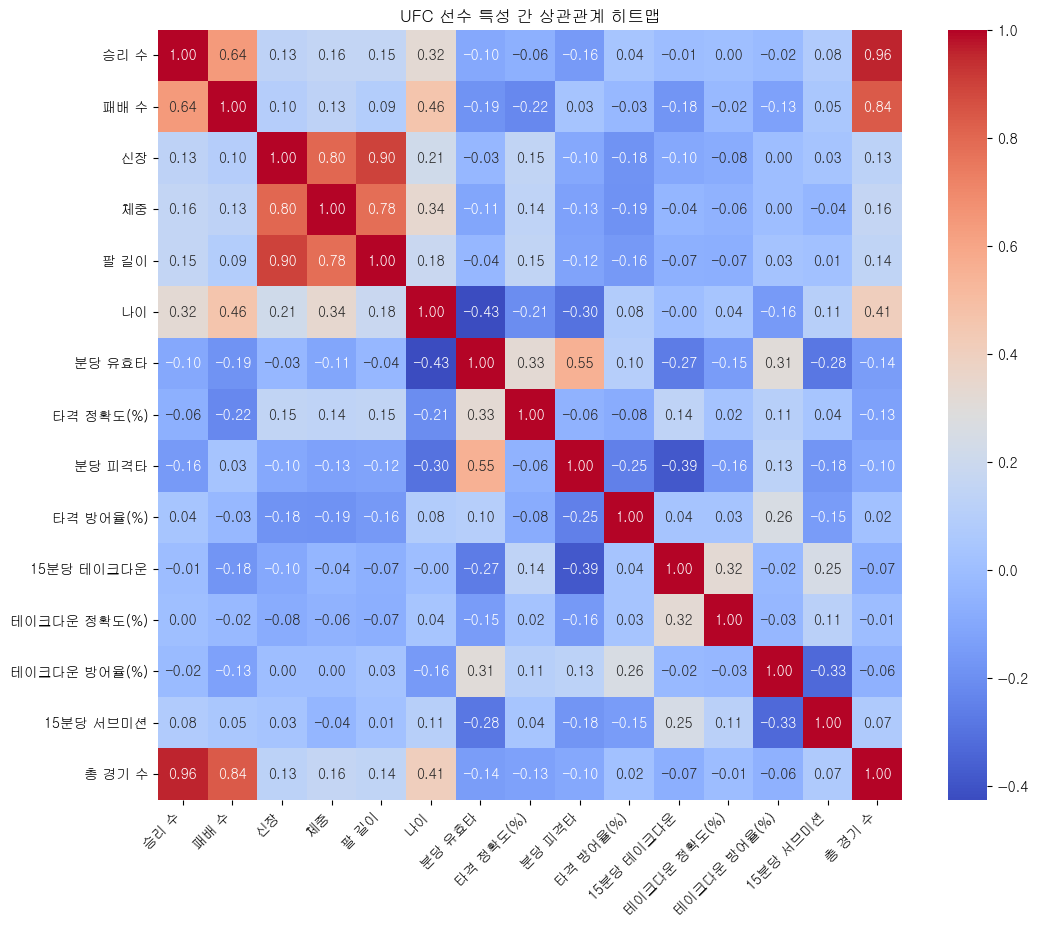

In [47]:
numeric_features = ['w_wins', 'w_losses', 'w_height', 'w_weight', 'w_reach', 'w_age', 'w_splm', 'w_str_acc', 'w_sapm', 'w_str_def', 'w_td_avg', 'w_td_acc', 'w_td_def', 'w_sub_avg', 'w_total_games']

feature_korean_names = {
    'w_wins': '승리 수',
    'w_losses': '패배 수',
    'w_height': '신장',
    'w_weight': '체중',
    'w_reach': '팔 길이',
    'w_age': '나이',
    'w_splm': '분당 유효타',
    'w_str_acc': '타격 정확도(%)',
    'w_sapm': '분당 피격타',
    'w_str_def': '타격 방어율(%)',
    'w_td_avg': '15분당 테이크다운',
    'w_td_acc': '테이크다운 정확도(%)',
    'w_td_def': '테이크다운 방어율(%)',
    'w_sub_avg': '15분당 서브미션',
    'w_total_games': '총 경기 수'
}

corr = df[numeric_features].rename(columns=feature_korean_names).corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")

plt.title('UFC 선수 특성 간 상관관계 히트맵')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()